# Importing Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import os
import sys
from matplotlib import pyplot as plt
from PIL import Image as pilimg
%matplotlib inline

# Dataset

In [ ]:
class Dataset:
  '''
    Returns an object of "Dataset" class that is used as input to 'Network' class.

    Paramters:

      'path' : str 
        path to main folder containing subfolders of images in a specific structure. For more info, see notes.
      
      'resize' : tuple of ints (width, height) (optional)
        shape of image in which it would be resized to. If no value is passed, no resizing will be done.

      'split_ratio' : tuple of int or float (train_size_percent, valid_size_percent, test_size_percent) Default = (60,20,20) (optional)
        ratio in which data will be split. The sum of the values must be equal to 100. 

      'zero_center': str = 'per_channel' or 'image'. Default = None (optional)
        defines zero centering of the data. It can take one of the folllowing values:

            'per_channel' : Subtract the mean per channel calculated over all images (like in VGG)
            'image' : Subtract mean image calculated over all images (like in AlexNet)

        If no value is passed, zero centering of the data will not be done

    Notes:

      - The class expects images to be in certain architecture of folders. There should be one main folder whose path will be passed
        to the parameter 'path'. Inside this main folder, there should be, equal to number of classes, folders. Each folder should be named
        with class label and inside it, there should be only images (in jpeg format, each having same size with shape(W,H,3)) of this class.
        Make sure there are no hidden folders.Everything else except folders and images will be ignored. 
    
      - The class expects images to be in uint8 format as it will map these values between 0 and 1 for better processing. 

  '''

  def __init__(self, path, resize = None, split_ratio = (60,20,20), zero_center = None):
 

    #check whether correct value for 'path' is provided

    if not os.path.isdir(path):
      sys.exit("Invalid Path provided. The path must be a valid directory")

    #store labels
    self.labels = [label for label in os.listdir(path) if os.path.isdir(os.path.join(path, label)) and not label.startswith('.') ]
    self.labels.sort()
    

    if len(self.labels) == 0:
      sys.exit("The directory provided is either empty or does not follow the specified architecture of folders. For more info, see the documentation of class 'Dataset'")
    else:

      data =list()

      for index,label in enumerate(self.labels):
      
        for image in os.listdir(os.path.join(path, label)):

          if image.endswith(".jpg"):
             
              #store path to images and annotate it with labels
              data.append([os.path.join(path, label, image), index])
          

    if len(data) == 0:
      sys.exit("The directories inside the specified folder are either empty or does not have images in jpg.")
    

    print("Total ", len(data), " images found with total ", len(self.labels), " classes")
    print('labels', self.labels)
    
    #Resize 
    if resize != None and len(resize) != 2:
        sys.exit("Parameter 'resize' can only take two integers as tuple")
      
    self.resize = resize

    #Splits the dataset
    if len(split_ratio) != 3:
      sys.exit("Invalid Values provided for parameter 'split_ratio'. It can take can only three values as tuple (train, valid, test)")
    
    elif np.sum(split_ratio) != 100:
      sys.exit("Invalid Values provided for parameter 'split_ratio'. train, valid and test must add up to 100.")
    
    else:
      self.train_data, self.valid_data, self.test_data = self.SplitData(data, split_ratio)

    #Calculate values for zero centering of the data
    if zero_center == None:
      self.mean = 0
    elif zero_center == 'per_channel':
      self.mean = self.PerChannelMean()
    elif zero_center == 'image':
      self.mean = self.MeanImage()
    else:
      sys.exit("Invalid Value Provided for parameter 'zero_center'. It can only take None, 'per_channel' or 'image'. ")





  def SplitData(self, data, split_ratio):
    '''
    Splits the dataset and returns training, validation and test dataset, each as tuple of (data, labels):
    
    Parameters:

    data: list of shape (total_images, 2) with 'path to image' in its first axis and 'label' in the second axis
      Dataset which needs to be split.
    
    'split_ratio' : tuple of int or float (train_size_percent, valid_size_percent, test_size_percent)
          ratio in which data will be split. The sum of the values must be equal to 100. 
    
    '''
    #Shuffle data    
    np.random.shuffle(data)
    
    #Split data
    train_data, valid_data, test_data = np.split(data, [int((split_ratio[0]/100)*len(data)), int(((split_ratio[0]+split_ratio[1])/100)*len(data))])
      
    return train_data, valid_data, test_data

    
    
  def PerChannelMean(self):
    '''
    Calculates and returns mean of each channel over training dataset as array of size 3 [R,G,B] :

    Notes:

      -  It expects image to be in RBG format with shape (width, height, 3)

    '''
    
    sum=np.array([0.0])
    
    for img, _ in self.train_data:

      #Read image
      img = pilimg.open(img)

      #Resize image
      if self.resize != None:      
        img =img.resize(self.resize)
       
      img = np.asarray(img)

      #map image between 0 and 1
      img  = img / 255

      #accumulate values
      sum = sum + img

    #return mean along three channels
    return np.sum(sum, axis=(0,1), keepdims=True)/(self.train_data.shape[0]*sum.shape[0]*sum.shape[1])
  
  
  def MeanImage(self):
    '''
    Calculates and returns mean image over training dataset as array of shape (M,N,3).

    Notes:

     -  It expects image to be in RBG format with shape (width, height, 3)

    '''
    sum=np.array([0.0])

    for img, _ in self.train_data:
      
      #Read image
      img = pilimg.open(img)

      #Resize image
      if self.resize != None:
        img =img.resize(self.resize)
       
      img = np.asarray(img)

      #map image between 0 and 1
      img = img / 255
      
      #accumulate values
      sum = sum + img

    #return mean image
    return sum/self.train_data.shape[0]



    
  def load_data(self, flag, batch):
    '''
    loads and returns a batch of images with labels of the specified dataset.
    The output returns two things:
        
        imgBatch: numpy array of images of shape ( batch, channels, rows, cols ):
        labelBatch: numpy array of labels of shape (batch, 1) 
        
    Parameters:

      'flag' : str = 'train', 'valid', or 'test'
        Specifies from which dataset to load the images

      'batch': list of integers [start, end]
        loads images from dataset with the specified indexes as start (inclusive) and end (not inclusive)
    
    '''
    #load path of images from the corresponding dataset

    if flag == 'train':
      files = self.train_data[batch[0] : batch[1]]
    elif flag == 'valid':
      files = self.valid_data[batch[0] : batch[1]]
    elif flag == 'test':
      files =self.test_data[batch[0] : batch[1]]
    else:
      sys.exit("Invalid value provided for parameter 'flag'. It can either be 'train', 'valid' or 'test'")
    

    #build batch of images and labels
    for index, data in enumerate(files):
      
      #Read image
      img = pilimg.open(data[0])

      #Resize image
      if self.resize != None:
        img =img.resize(self.resize)
       
      img = np.asarray(img)
      
      #map image between 0 and 1
      img  = img / 255

      #zero center the data
      img = img - self.mean      
      
      #reshape image to (depth, width, height)
      img = np.array([img[:,:,0],img[:,:,1],img[:,:,2]])
      

      #for creating batch of images
      if index == 0:
        imgBatch = np.zeros([len(files), img.shape[0], img.shape[1], img.shape[2]] )

        #by filling with value more than total number of labels, it makes sure
        #that all values are replaced with proper label (as this will be checked by loss fnt in case improper value is passed)
        labelBatch = np.full((len(files), 1) , fill_value = len(self.labels)+1 )
        
      imgBatch[index] = img

      labelBatch[index] = data[1]

      
    return imgBatch, labelBatch


# Convolution Layer

In [ ]:
class Conv:
  '''
    Returns an object of "Conv" class that is used as Convolution Layer in CNNs.

    Paramters:

        'number_of_filters' : non-zero, positive, int 
          Number of filters that will be convolved with the activation maps
        
        'filter_size' : non-zero, positive, odd, int 
          size of the square filter
        
        'stride' : non-zero, positive, int. Default=1 (optional)
          size of step to take in horizontal and vertical direction

        'zero_padding' : positive, int. Default=0 (i.e. no zero padding) (optional)
          number of rows and columns of zeros that need to be added around the activation maps.
            For example, if it is specified to be as 2 and activations has a shape of (batch, channels, rows, cols), then 
            after zero padding, the new shape of activations will be (batch, channels, rows + 4, cols + 4) with zeros above and below, right and left of the axis -1 and -2.

    
    Notes:
    
      -   Combination of stride, zero padding, last two axis of both filters and activation maps must be 
          such that it results an whole number for the following equation:

                 For each axis: 
                         O = ( ( R - F + 2P ) / S ) + 1 
                 where
                         O = size of output axis
                         R = size of activation map axis
                         F = size of filter
                         P = amount of zero padding
                         S = stride
    
  '''
  
  def __init__(self, number_of_filters, filter_size, stride=1, zero_padding=0 ):

    
    #Check whether valid values are provided for paramters and store accordingly

    if number_of_filters <= 0 or number_of_filters % 1 != 0: 
      sys.exit("Invalid Value provided for parameter 'number_of_filters'. It must be non-zero, positive integer.")
    else:
      self.number_of_filters =number_of_filters

    if filter_size <= 0 or filter_size % 1 != 0 or filter_size % 2 == 0: 
      sys.exit("Invalid Value provided for parameter 'filter_size'. It must be non-zero, positive, odd integer")
    else:
      self.filter_size=filter_size
    
    if stride <= 0 or stride % 1 !=0:
      sys.exit("Invalid Value provided for parameter 'stride'.It must be non-zero, positive integer.")
    else:
      self.stride = stride
    
    if zero_padding < 0 or zero_padding  % 1 !=0:
      sys.exit("Invalid Value provided for parameter 'zero_padding'. It must be positive integer.")
    else:
      self.zero_padding=zero_padding

    # Variables associated with this layer
    self.weights=np.array([])
    self.dW=np.array([])

    self.bias=np.array([])
    self.dB=np.array([])

    self.inputs = np.array([])

    

  def forward(self, activations, train=False):
    '''
      Performs Convolution of each filter with each image and returns the result with shape = (b, d, r, c):

          b = batch (same as 'activations')
          d = channels (same as 'number of filters')
          r, c = Rows and Columns (calculated using the formula described in the constructor of the class) 

      Parameters:

        'activations' : numpy array of shape (batch, channels, rows, columns)
          Activation maps which will be convolved with filters

        'train' : bool. Default=False (optional)
          whether training of the layer is being carried out or not 
    '''

    if self.weights.shape[0] != self.number_of_filters: 
      sys.exit("Error in number of filters. Number of filters with weights do not match with number of filters specified") 

    if self.bias.shape[0] != self.number_of_filters:
      sys.exit("Error in number of filters. Number of filters with  bias do not match with number of filters specified") 

    if activations.shape[1] != self.weights.shape[1]:
      sys.exit("Depth of activations do not match with depth of filters. Check the channels of activation map and filters") 
    
    if self.bias.shape[1] != 1:
        sys.exit("Invalid Shape of parameter 'bias'. It must be of shape (number_of_filters,1)")
    
    if activations.shape[-1] != activations.shape[-2]:
        sys.exit("The rows and columns (i.e axis =-1 and -2) of Activations must be same for convolution. ")

    if train:
      self.inputs = activations

    #Apply Zero padding
  
    pw=[[0,0]]*(np.size(activations.shape)-2) + [[self.zero_padding, self.zero_padding]]*2 #list of pad widths for each axis
    activations = np.pad(activations, pw, 'constant', constant_values=0)

    #Convolution
    output_row_col = ((np.array(activations.shape[-2:]) - self.weights.shape[-2:])/self.stride)+1
    
    #check whether filter and activations convolve properly
    if any(output_row_col%1 !=0) :
      print('Properties at this layer:')
      print('\t Layer type = Convolution')
      print('\t Size of Activations (with zero padding) = ', activations.shape )
      print('\t\t\t ( Batch, Channels, Rows, Columns )')
      print('\t Size of Filters = ', self.weights.shape )
      print('\t\t\t ( Number of Filters, Channels, Rows, Columns )')
      print('\t Padding = ',  self.zero_padding )
      print('\t Stride = ' , self.stride )
      
      sys.exit('Undefined Values at Boundary of Activation Map: '\
               'Combination of stride, zero padding, last two axis (axis=-1,-2) of both filters and activation maps is not correct.'\
               'Properties at this layer are printed above. For more, see the documentation of "Conv" class')

    
    #array of zeros for output of convolution operation
    output=np.zeros((activations.shape[0], self.weights.shape[0]) + tuple(output_row_col.astype(np.int)))
    
    if train:
      self.output_shape=output.shape

    for filter in range(self.number_of_filters):

      for rows in range(output.shape[-2]):

        for cols in range(output.shape[-1]):
          
          #adusting values with stride
          r=rows*self.stride
          c=cols*self.stride
          
          #extract part of image, perform convolution and assign it to new map
          output[:,filter, rows, cols]=np.sum(activations[:,:, r:r + self.weights.shape[-2] , c:c + self.weights.shape[-1]] * self.weights[filter,:,:,:], axis=(1,2,3)) + self.bias[filter]
    
    return output

  def backward(self, dL):
    '''
      Calculates gradients with respect to inputs, weights and bias of this layer
      and returns gradient w.r.t input of shape (same as input to this layer):
          
      Parameters:

        'dL' : numpy array of shape (same as output of this layer)
          Global gradient flowing from the next layer

    '''

    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the Convlutional layer")   

    #gradient w.r.t bias
    self.dB = np.sum(dL, axis=(0,2,3)).reshape(-1,1)

    #gradient w.r.t weights

    #apply zero padding to inputs of the layer
    pw=[[0,0]]*(np.size(self.inputs.shape)-2) + [[self.zero_padding, self.zero_padding]]*2
    X = np.pad(self.inputs, pw, 'constant', constant_values=0)

    self.dW = np.zeros(self.weights.shape)

    #Valid Convolution (X,dL)
    for filter in range(self.number_of_filters):

      for rows in range(self.weights.shape[-2]):

        for cols in range(self.weights.shape[-1]):
        
          #adusting values with stride
          r=rows*self.stride
          c=cols*self.stride
          
          #concentenate dL to match depth of weights
          temp=np.concatenate( [dL[:,filter, np.newaxis, :,:]] * X.shape[1],  axis=1)

          #dW
          self.dW[filter, :, rows, cols]= np.sum(temp*X[:,:, r:r + dL.shape[-2] , c:c + dL.shape[-1]], axis=(0,2,3))

    #gradient w.r.t inputs

    #apply zero padding to weights of the layer
    pw=[[0,0]]*(np.size(self.weights.shape)-2) + [[dL.shape[-1]-1,dL.shape[-1]-1]]*2
    W = np.pad(self.weights, pw, 'constant', constant_values=0)

    #calculate shape of dX
    output_row_col = ((np.array(W.shape[-2:]) - dL.shape[-2:]) / self.stride) +1
    dX = np.zeros((dL.shape[0], self.weights.shape[1]) + tuple(output_row_col.astype(np.int)))

    #flip the weights
    W=np.flip(W, axis=(-1,-2))

    #Full Convlution (rotated weights, dL)
    for filter in range(self.number_of_filters):

        for rows in range(dX.shape[-2]):

          for cols in range(dX.shape[-1]):
          
            #adusting values with stride
            r=rows*self.stride
            c=cols*self.stride

            #concentenate dL to match depth of weights
            temp=np.concatenate([dL[:,filter, np.newaxis,:,:]]*W.shape[1], axis=1)

            #dX
            dX[:, :, rows, cols] += np.sum(temp*W[filter,:, r:r + dL.shape[-2] , c:c + dL.shape[-1]], axis=(2,3))


    #Flip the result 
    dX=np.flip(dX, axis=(-1,-2)) 

    #remove zero padding and return dX
    return dX[:,:, self.zero_padding:dX.shape[-2]-self.zero_padding, self.zero_padding:dX.shape[-1]-self.zero_padding]

# Activation Functions

## Hyperbolic Tangent Function

In [ ]:
class Tanh:
  '''
    Returns an object of class "Tanh" that can be used as activation function in CNNs
  
  '''
  
  def forward(self, activations, train=False):
    '''
      Applies Hyperbolic Tangent function to the input and returns the result

      Parameters:
        
        'activations' : numpy array
          activations on which tanh function will be applied
        
        'train' : bool. Default=False
          whether training of the layer is being carried out or not 
    '''

    #apply tanh funciton
    output = np.tanh(activations)

    # calculate local gradient
    if train:
      self.output_shape = output.shape
      self.dT = 1-np.square(output)
    
    return output

 
  def backward (self, dL):
    '''
      Calculates and returns gradient with respect to inputs to this layer

      Parameters:
        
        'dL' : numpy array of shape (same as output of this layer) 
          global gradient (flowing from the next layer)
  
    '''
    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the tanh layer") 
    
    #dX
    return dL*self.dT

## ReLU


In [ ]:
class ReLU:
  '''
    Returns an object of "ReLU" class that can be used as activation function in CNNs
  
  '''


  def forward(self, activations, train=False):
    '''
      Applies ReLU function to the input and returns the result

      Parameters:
        
        'activations' : numpy array
          activations on which ReLU function will be applied
        
        'train' : bool. Default=False
          whether training of the layer is being carried out or not 
    '''

    #apply ReLU
    output = np.maximum(0, activations)

    #calculate local gradient
    if train:
      self.output_shape = output.shape
      self.dR =  1 * (activations > 0)

    return output 


  def backward (self, dL):
    '''
      Calculates and returns gradient with respect to inputs to this layer

      Parameters:
        
        'dL' : numpy array of shape (same as output of this layer) 
          global gradient (flowing from the next layer)
  
    '''
    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the ReLU layer") 
    
    #dX
    return dL*(self.dR)


## Leaky ReLU

In [ ]:
class LeakyReLU:
  '''
    Returns an object of "LeakyRelU" class that can be used as activation function in CNNs

    Parameters:
      
      'slope' : int or float. Default=0.01 (optional)
        slope of the function for negative values of input i.e it represents 'a' in the following formula:

            f(x) = max(ax, x)
  
  '''
  def __init__(self, slope=0.01):
    
      self.slope = slope


  def forward(self, activations, train=False):
    '''
      Applies LeakyReLU function to the input and returns the result

      Parameters:
        
        'activations' : numpy array
          activations on which LeakyReLU function will be applied
        
        'train' : bool. Default=False
          whether training of the layer is being carried out or not 
    '''

    #apply LeakyReLU
    output = np.maximum(self.slope*activations, activations)

    #calculate local gradient
    if train:
      self.output_shape = output.shape
      self.dLR =  np.ones(activations.shape)
      self.dLR [activations < 0] = self.slope

    return output 


  def backward (self, dL):
    '''
      Calculates and returns gradient with respect to inputs to this layer

      Parameters:
        
        'dL' : numpy array of shape (same as output of this layer) 
          global gradient (flowing from the next layer)
  
    '''

    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the LeakyReLU layer") 

    #dX
    return dL*(self.dLR)


## Softmax

In [ ]:
class Softmax:
  '''
    Returns an object of "Softmax" class that can be used with cross entropy loss in CNNs
  
  '''

  def forward(self, activations, train=False):
    '''
      Applies Softmax function to the input and returns the result

      Parameters:
        
       'activations' : numpy array of shape (batch, number_of_classes, 1, 1) or (Batch, number of classes)
          activations on which Softmax funciton will be applied
        
        'train' : bool. Default = False
          whether training of the layer is being carried out or not 
    '''

    if train:
      self.input_shape = activations.shape

    
    #check for correct shape of activations
    if len(activations.shape) == 4:
      
      if activations.shape[-2:] != (1,1):
        sys.exit("When using Global Average Poooling Technique (i.e the len of shape of activations is 4),"\
         "it can only be of form (batch, number of classes, 1,1)")
      else:  
        activations = activations.reshape(activations.shape[0], activations.shape[1]) #reshape activations
    
    elif len(activations.shape) == 2:
      pass
    
    else:
      sys.exit("The number of dimensions of activations are not correct. It can either be two or four")


    #unnormalized probabilities
    unnorm_prob = np.exp(activations)  #in order to avoid NaN

    #normalized probabilities
    output = unnorm_prob / (np.sum(unnorm_prob, axis=1).reshape(-1,1))

    self.activations = output
   
    #calculate local gradient
    if train:
      self.output_shape = output.shape
      
      # derivative of this layer results in a jacobian of size (nunber of classes, number of classes) for each example.
      # however, since we are dealing with one hot encoded values, the important values in jacobian are at the diagonals
      # which are calcualted as follows:
      self.dS = np.multiply(output, (1-output))

    return output

  def backward (self, dL):
    '''
      Calculates and returns gradient with respect to inputs to this layer

      Parameters:
        
        'dL' : numpy array of shape (same as output of this layer) 
          global gradient (flowing from the next layer)
  
    '''
    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the Softmax layer") 
    
    #dX
    return (dL*self.dS).reshape(self.input_shape)

# Pooling Layer

In [ ]:
class Pool:
  '''
    Returns an object of "Pool" class that can be used as Pooling Layer in CNNs.

    Paramters:

      'pooling_type' : str = 'max', 'average' or 'global' 
        It defines which type of pooling to be applied on the activation maps. It can take one of the following values:

          'max': outputs maximum value of region of activation map under the window
          'average' or 'global': outputs mean value of region of activation map under the window

      'filter_size' : non-zero, positive, int (optional when using 'pooling_type' = 'global')
        size of the square window that needs to operate over each activation map
      
      'stride' : non-zero, positive, int. Default=2 (optional)
        size of step to take in horizontal and vertical direction

      'zero_padding' : positive, int. Default=0 (i.e. no zero padding) (optional)
        number of rows and columns of zeros that needs to be added around each activation map.
          For example, if it is specified to be as 2 and activations has a shape of (batch, channels, rows, cols), then 
          after zero padding, the new shape of activations will be (batch, channels, rows + 4, cols + 4) with zeros above and below, right and left of the axis -1 and -2.

  Notes:

    -  Combination of stride, zero padding, last two axis of both filter and activation maps must be 
    such that it results in an whole number for the following equation:

              For each axis: 
                      O = ( ( R - F + 2P ) / S ) + 1 
              where
                      O = size of output axis
                      R = size of activation map axis
                      F = size of filter
                      P = amount of zero padding
                      S = stride

    -  When using 'global' as 'pooling type', following parameters will be set as:
              
              'filter_size' = size of last two axis of activation map (rows, cols)
              'stride' = 1
              'zero_padding' = 0
      
       Thus, these parameters are not required. In case, if they are provided then they will be overwritten.
  
  '''
  def __init__(self, pooling_type, filter_size=None, stride=1, zero_padding=0 ):

    self.pooling_type = pooling_type

    #assign function for corresponding pooling type
    if pooling_type == 'max':
      self.poolFnt=np.max
    
    elif pooling_type == 'average':
      self.poolFnt=np.mean
   
    elif pooling_type == 'global':
      
      self.poolFnt = np.mean
      self.stride = 1
      self.zero_padding = 0

    else:
      sys.exit("Invalid Value provided for parameter 'pooling_type'.It can only be 'max', 'average' or 'global' (with single quotes).")


    #Check for errors in input values

    if pooling_type != 'global' and filter_size == None:
      sys.exit("When not using 'global' as pooling type, 'filter_size' must be provided")
  
    if pooling_type != 'global':

      if filter_size <= 0 or filter_size % 1 != 0: 
        sys.exit("Invalid Value provided for parameter 'filter_size'. It must be non-zero, positive integer.")
      else:
        self.filter_size=filter_size
      
      if stride <= 0 or stride % 1 !=0:
        sys.exit("Invalid Value provided for parameter 'stride'.It must be non-zero, positive integer.")
      else:
        self.stride = stride
      
      if zero_padding < 0 or zero_padding  % 1 !=0:
        sys.exit("Invalid Value provided for parameter 'zero_padding'.It must be positive integer.")
      else:
        self.zero_padding=zero_padding

    
  def forward(self, activations, train=False):
    '''
      Performs Pooling of the activation maps and returns the result (shape = (b, d, r, c)):

          b = batch (same as 'activations')
          d = channels (same as 'activations')
          r, c = Rows and Columns (calculated using the formula described in the constructor of the class) 

      Parameters:

      'activations' : numpy array of shape (batch, channels, rows, columns)
        Activation map upon which pooling will be performed

      'train' : bool. Default = False (optional)
        whether training of the layer is being carried out or not 

    '''
    #check whether valid value for activations is provided

    if len(activations.shape) != 4:
      sys.exit("The shape of the activations is incorrect. It must be (batch, channels, rows, cols). ")

    if activations.shape[-1] != activations.shape[-2]:
        sys.exit("The rows and columns (i.e axis =-1 and -2) of Activations must be same for pooling. ")
    
    #Adjust filter size for global average pooling 
    if self.pooling_type == 'global':
      self.filter_size = activations.shape[-1]
    
    #Apply Zero padding
    pw=[[0,0]]*(np.size(activations.shape)-2) + [[self.zero_padding, self.zero_padding]]*2 #list of pad widths for each axis
    activations = np.pad(activations, pw, 'constant', constant_values=0)

    # Calculate shape of output
    output_row_col = ( ( np.array(activations.shape[-2:] ) - self.filter_size ) / self.stride) +1

    #check whether filter and activations convolve properly
    if all(output_row_col%1 !=0) :
      print('Properties at this layer:')
      print('\t Layer = Pooling with ', self.pooling_type )
      print('\t Size of Activations (with zero padding) = ', activations.shape )
      print('\t\t\t ( batch, channels, rows, columns )')
      print('\t Size of window = ', (self.filter_size, self.filter_size) )
      print('\t Padding = ',  self.zero_padding )
      print('\t Stride = ' , self.stride )
      
      sys.exit('Undefined Values at Boundary of Activation Map: '\
               'Combination of stride, zero padding, last two axis (axis=-1,-2) of both window and activation maps is not correct.'\
               'Properties at this layer are printed above. For more, see the documentation of "Pool" class')
      
    
    #array of zeros for output of pooling operation
    output=np.zeros((activations.shape[0:2] + tuple(output_row_col.astype(np.int))))
    
    if train:
      self.inputs_shape = activations.shape
      self.output_shape = output.shape
    
      #for storing indices for local gradient
      self.indices=np.empty((output.shape[-2:]), object)


    for rows in range(output.shape[-2]):

      for cols in range(output.shape[-1]):
        
        #adusting values with stride
        r=rows*self.stride
        c=cols*self.stride
        
        #pooling 
        result=self.poolFnt(activations[:,:, r:r + self.filter_size , c:c + self.filter_size], axis=(-2,-1))

        if train:

          # find indices for local gradient when 'pooling_type' is 'max'
          if self.poolFnt.__name__ == 'amax':

            #indices where highest value occurs 
            value_indices = np.where(np.equal(result[:,:,np.newaxis, np.newaxis], activations[:,:, r:r + self.filter_size, c:c + self.filter_size] ))
            
            #remove extra indices if multiple highest values exist
            temp = np.array([value_indices[0], value_indices[1], value_indices[2], value_indices[3]]).T
            _, uniq_indices = np.unique(np.array([value_indices[0],value_indices[1]]).T, return_index=True, axis=0) 
            
            #store the indices
            self.indices[rows,cols]= tuple([np.array(i) for i in temp[uniq_indices].T ])


        output[:,:, rows, cols] = result
    

    return output

  def backward(self, dL):
    '''
      Calculates and returns gradients with respect to input of this layer
          
      Parameters:

      'dL' : numpy array of shape (same as output of this layer)
        Global gradient flowing from the next layer

    '''

    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the Pooling layer")   

    dX=np.zeros(self.inputs_shape)
    
    #calculate Gradient 
    for rows in range(dL.shape[-2]):

      for cols in range(dL.shape[-1]):
        
        #adusting values with stride
        r=rows*self.stride
        c=cols*self.stride

        #dX
        if self.poolFnt.__name__ == 'amax':
          dX[:,:, r:r + self.filter_size , c:c + self.filter_size][self.indices[rows,cols]] += dL[:,:,rows, cols].flatten()
        
        else:
          dX[:,:, r:r + self.filter_size , c:c + self.filter_size] += (dL[:,:,rows,np.newaxis, cols, np.newaxis]/(self.filter_size*self.filter_size))

    #remove zero padding
    return dX[:,:, self.zero_padding:dX.shape[-2]-self.zero_padding, self.zero_padding:dX.shape[-1]-self.zero_padding]


# Fully Connected Layer

In [ ]:
class FC:
  '''
    Returns an object of "FC" class that can be used as fully connected layer in CNNs

    Parameters:

      'neurons' : non-zero, positive, int
        Number of Neurons in the Fully Connected Layer
  '''
  def __init__(self, neurons):
    
    #check whether valid value is provided for 'neurons'
    if neurons <= 0 or neurons % 1 != 0: 
        sys.exit("Invalid Value provided for parameter 'neurons'. It must be non-zero, positive integer.")
    else:
        self.neurons = neurons

    #variables asscoiated with this layer  
    
    self.weights=np.array([])
    self.dW=np.array([])

    self.bias=np.array([])
    self.dB=np.array([])
  
  def forward(self, activations, train=False):
    '''
      Performs the following operation and returns the result of shape = (Batch, neurons in this layer)

          result = activations*weight + bias

      Parameters:

        'activations' : numpy array of shape (batch, channels, rows, columns) or (Batch, neurons in previous layer)
          activations which will be connected to fully connected layer
        
        'train' : bool. Default = False (optional)
          whether training of the layer is being carried out or not 
      
      Notes:

        -  If 'activations' is of shape (batch, channels, rows columns), then it will be reshaped into (Batch, Channels*Rows*Cols)
   
   '''
    if train:
      self.inputs_shape = activations.shape

    #Check whether valid values are provided for parameters

    if len(activations.shape) == 4:
      activations = activations.reshape(activations.shape[0], np.prod(activations.shape[1:]))
  
    elif len(activations.shape) == 2:
      pass
    
    else:
      sys.exit("The number of dimensions of activations are not correct. It can either be two or four")

    
    if self.weights.shape[1] != self.neurons or self.bias.shape[0] != self.neurons:
      sys.exit("The number of neurons in weights or bias do not match with number of neurons specified.")
       
    if activations.shape[1] != self.weights.shape[0]:
      sys.exit("There is a mismatch in number of neurons in previous layer between activations and weights. The second axis of activations do not match with the first axis of weights.")
    
    if self.bias.shape[1] != 1:
        sys.exit("Invalid Shape of parameter 'bias'. It must be of shape (number of neurons,1)")
    
    self.bias = self.bias
    
    #Apply the Linear function
    output = np.matmul(activations, self.weights) + self.bias.reshape(1,-1)
    
    #For gradients
    if train:
      self.inputs = activations
      self.output_shape = output.shape

    return output



  def backward(self, dL):
    '''
      Calculates gradients with respect to weights and bias of this layer. 
      It also calculates and returns gradeints w.r.t inputs to this layer.
          
      Parameters:

      'dL' : numpy array of shape (same as output of this layer)
        Global gradient flowing from the next layer

    '''
    if dL.shape != self.output_shape:
      sys.exit("The shape of global gradient must be same as output of the Fully Connected layer")

    #dW
    self.dW = np.dot(self.inputs.T, dL)

    #dB
    self.dB = np.sum(dL, axis=0).reshape(-1,1)

    #dX
    return np.dot(dL, self.weights.T).reshape(self.inputs_shape)

# Cross Entropy Loss layer

In [ ]:
class CELoss:
  '''
    Returns an object of "CELoss" class that can be used as cross entropy loss for Multiclass Classification in CNNs

    Parameters:

      'number_of_classes' : non-zero, positive, int
        Number of classes present in the dataset
    
      Notes:

        - 'actual_labels' even though not one hot encoded, are used in calculations in such a way that they work like one hot encoded values.

  '''
  def __init__(self, number_of_classes):

    #check whther valid value is provided for 'number_of_classes'
    if number_of_classes <= 0 or number_of_classes % 1 != 0: 
      sys.exit("Invalid Value provided for parameter 'number_of_classes'. It must be non-zero, positive integer.")
    else:
      self.number_of_classes = number_of_classes
    

  def forward (self, activations, labels, train=False):
    '''
    Calculates and returns total Cross Entropy loss (not divided by total number of training examples).

    Parameters:

      'activations' : numpy array of shape (batch, number of classes)
        activations which will used for calculating cross entropy loss

      'labels' : numpy array of shape (batch, 1)
        label of each training example. They must be positive integers and must range between 0 and number_of_classes - 1.

       'train' : bool. Default = False (optional)
          whether training of the layer is being carried out or not 
    
    Notes:

      - Natural Log is used for the calculation of loss function   

    '''

    #Check whether inputs' shape and values are correct
  
    if activations.shape[1] != self.number_of_classes:
      sys.exit("The number of classes specified do not match with the number of neurons in the last layer. These two must be same")

    if activations.shape[0] != labels.shape[0]:
      sys.exit("There is a mismatch in number of examples in activations and in labels provided.")
    
    if labels.shape[1] != 1 or len(labels.shape) != 2:
      sys.exit("The shape of 'labels' is not correct. It can only be (batch,1)")
    
    unique_labels = np.unique(labels)

    if any(unique_labels < 0) or any(unique_labels % 1 != 0): 
      sys.exit("Invalid Value provided for parameter 'labels'. It can only be positive integer.")
    
    if len(unique_labels) > self.number_of_classes: 
      sys.exit("There are more classes in 'labels' than specified.")
    
    if not set(unique_labels).issubset( range(0, self.number_of_classes) ): 
      sys.exit("The integers in 'labels' do no fall in range between 0 and number of classes - 1.")

    #Annotating labels with number of training example
    label_with_img_no = tuple( [range(activations.shape[0]), labels.reshape(-1)] )

    #calculate local gradient
    if train:
      self.dC = np.zeros(activations.shape, dtype=np.float)
      self.dC [label_with_img_no] = -1/(activations[label_with_img_no])

    #calculate loss
    loss = - np.log( activations[label_with_img_no])

    return np.sum( loss )


  def backward(self, dL):
    '''
      Calculates and returns gradients with respect to inputs of this layer. 
      
      Parameters:

      'dL' : int/float
        Global gradient flowing from the next layer

    '''
    #dX
    return dL*self.dC

# Evaluation Metrics

## Classification Accuary

In [ ]:
def ClassAccu(activations, actual_labels):
  '''
     Returns number of correctly classified examples in the batch

     Parameters:

       'activations' : numpy array of shape (batch, number of classes)
         activations of output layer (layer before loss function).  
      
       'actual_labels' : numpy array of shape (batch,1)
         actual labels of each example  
      
      Notes:

        - 'actual_labels', even though not one hot encoded, are used in calculations in such a way that they work like one hot encoded values.

  '''
    
  #indexes of highest values
  pred_labels=np.where(np.max(activations, axis=1, keepdims=True) == activations )
  
  #remove those rows in case when more than one class have equal highest score
  temp=np.array([pred_labels[0],pred_labels[1]]).T
  _,indices=np.unique(pred_labels[0], return_index=True) 

  #calculate and return percentage of correctly classified examples
  return np.sum(temp[indices][:,1] == actual_labels.reshape(-1))

## Confusion Matrix

In [ ]:
def ConfMatrix(activations, actual_labels):
  '''
     Returns Confusion Matrix (numpy array) of shape (number of classes, number of classes)
         Rows represent predicted labels and Columns represent actual labels.

     Parameters:

       'activations' : numpy array of shape (batch, number of classes)
         activations of output layer (layer before loss function).  
      
       'actual_labels' : numpy array of shape (batch,1)
         actual labels of each example  
    
    Notes:

    - 'actual_labels', even though not one hot encoded, are used in calculations in such a way that they work like one hot encoded values.
  '''
    
  #indexes of highest values
  pred_labels = np.where(np.max(activations, axis=1, keepdims=True) == activations )

  #remove those rows in case when more than one label have equal highest score
  temp = np.array([pred_labels[0],pred_labels[1]]).T
  _,indices = np.unique(pred_labels[0], return_index=True) 

  #concentate indices of predicted and actual labels
  temp = np.concatenate((temp[indices][:,1].reshape(-1,1), actual_labels), axis=1)

  #confusion matrix
  cm = np.zeros((activations.shape[1], activations.shape[1]))
  for x,y in temp:
    cm[x, y] = cm[x, y] +1

  return cm

# Optimizers

## Gradient Descent

In [ ]:
class GD:
  '''
    Returns an object of "GD" class that can be used as optimizer in CNNs.
    It uses Vanilla Gradient Descent algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

  '''
  def update(self, layer, batch_size, lmbda, lr):
    '''
      Updates parameters of the layer

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non-zero positive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 

      #adjust for regularization and update paramters
      layer.weights += - lr * ((layer.dW + (lmbda*layer.weights))/batch_size)
      layer.bias += -lr *(layer.dB/batch_size)
    
    else:
      sys.exit("Invalid Layer for parameters updation")


## Gradient Descent with Momentum

In [ ]:
class GDM:
  '''
    Returns an object of "GDM" class that can be used as optimizer in CNNs.
    It uses Gradient Descent with Momentum algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

    Parameters:

      'rho' : int or float
        value of "friction"
  '''
  def __init__(self, rho):
    self.rho = rho


  def update(self, layer, batch_size, lmbda, lr):
    '''
      Updates parameters of the layer 

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non-zero postive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 
      
      #adjust for regularization
      total_dW = (layer.dW + (lmbda*layer.weights))/batch_size
      total_dB = layer.dB/batch_size

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dW_vel'):
        layer.dW_vel = 0 
      
      print('dW_vel inside', dW_vel)
      layer.dW_vel = (self.rho*layer.dW_vel) + total_dW
      layer.weights += - lr * layer.dW_vel

      #adjust for first iteration and update bias
      if not hasattr(layer, 'dB_vel'):
        layer.dB_vel = 0

      layer.dB_vel = (self.rho*layer.dB_vel) + total_dB 
      layer.bias += - lr * layer.dB_vel
    
    else:
      sys.exit("Invalid Layer for parameters updation")

## Nesterov Momentum

In [ ]:
class NM:
  '''
    Returns an object of "NM" class that can be used as optimizer in CNNs.
    It uses Nestrov Momentum algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

    Parameters:

      'rho' : int or float
        value of "friction"
  '''
  def __init__(self, rho):
    self.rho = rho


  def update(self, layer, batch_size, lmbda, lr):
    '''
      Updates parameters of the layer 

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non zero positive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 
      
      #adjust for regularization
      total_dW = (layer.dW + (lmbda*layer.weights))/batch_size
      total_dB = layer.dB/batch_size

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dW_vel'):
        layer.dW_vel = 0 
      
      old_dW_vel = layer.dW_vel
      layer.dW_vel = (self.rho*layer.dW_vel) - (lr * total_dW)
      layer.weights += - (self.rho*old_dW_vel) + ((1+self.rho) * layer.dW_vel)

      #adjust for first iteration and update bias
      if not hasattr(layer, 'dW_vel'):
        layer.dB_vel = 0 
       
      old_dB_vel = layer.dB_vel
      layer.dB_vel = (self.rho*layer.dB_vel) - (lr * total_dB)
      layer.bias += - (self.rho*old_dB_vel) + ((1+self.rho) * layer.dB_vel)
    
    else:
      sys.exit("Invalid Layer for parameters updation")

## AdaGrad

In [ ]:
class AG:
  '''
    Returns an object of "AG" class that can be used as optimizer in CNNs.
    It uses AdaGrad algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

  '''

  def update(self, layer, batch_size, lmbda, lr):
    '''
      Updates parameters of the layer 

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non zero positive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 
      
      #adjust for regularization
      total_dW = (layer.dW + (lmbda*layer.weights))/batch_size
      total_dB = layer.dB/batch_size

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dW_squared'):
        layer.dW_squared = 0 
      
      layer.dW_squared += total_dW * total_dW
      layer.weights += - (lr*total_dW)/(np.sqrt(layer.dW_squared) + 0.00000001 )

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dB_squared'):
        layer.dB_squared = 0 
      
      layer.dB_squared += total_dB * total_dB
      layer.bias += - (lr*total_dB)/(np.sqrt(layer.dB_squared) + 0.00000001 )
    
    else:
      sys.exit("Invalid Layer for parameters updation")

## RMSProp

In [ ]:
class RP:
  '''
    Returns an object of "RP" class that can be used as optimizer in CNNs.
    It uses RMSProp algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

    Parameters:

      'decay_rate' : int or float
        value of rate of decay of learning rate
  '''
  def __init__(self, decay_rate):
    self.decay_rate = decay_rate


  def update(self, layer, batch_size, lmbda, lr):
    '''
      Updates parameters of the layer 

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non-zero positive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 
      
      #adjust for regularization
      total_dW = (layer.dW + (lmbda*layer.weights))/batch_size
      total_dB = layer.dB/batch_size

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dW_squared'):
        layer.dW_squared = 0 
      
      layer.dW_squared = (self.decay_rate * layer.dW_squared) + (( 1 - self.decay_rate ) * (total_dW * total_dW))
      layer.weights += - ( lr*total_dW )/( np.sqrt(layer.dW_squared) + 0.00000001 )

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dB_squared'):
        layer.dB_squared = 0 
      
      layer.dB_squared = (self.decay_rate * layer.dB_squared) + (( 1 - self.decay_rate ) * (total_dB * total_dB))
      layer.bias += - (lr*total_dB)/(np.sqrt(layer.dB_squared) + 0.00000001 )
    
    else:
      sys.exit("Invalid Layer for parameters updation")

## Adam

In [ ]:
class AD:
  '''
    Returns an object of "AD" class that can be used as optimizer in CNNs.
    It uses Adam algorithm to update the parameters.
    Further, it may be noted that it uses L2 regularization

    Parameters:

      'beta1' : int or float

      'beta2' : int or float

  '''
  def __init__(self, beta1, beta2):
    self.beta1 = beta1
    self.beta2 = beta2


  def update(self, layer, batch_size, lmbda, lr, iter):
    '''
      Updates parameters of the layer 

      Parameters:

        'layer' : object of class 'Conv' or 'FC'
          layer whose weights will be updated
        
        'batch_size' : non zero postive int 
          size of batch.

        'lmbda' : int or float
          value of regulariztion parameter
        
        'lr' : int or float
          value of learning rate
        
        'iter' : non zero positive int
          number of iteration

    '''
    if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC': 
      
      #adjust for regularization
      total_dW = (layer.dW + (lmbda*layer.weights))/batch_size
      total_dB = layer.dB/batch_size

      #adjust for first iteration and update weights
      if not hasattr(layer, 'dW_first_moment'):
        layer.dW_first_moment = 0 
      if not hasattr(layer, 'dW_second_moment'):
        layer.dW_second_moment = 0

      layer.dW_first_moment = (self.beta1 * layer.dW_first_moment) + ( (1-self.beta1) *total_dW)   
      layer.dW_second_moment = (self.beta2 * layer.dW_second_moment) + (( 1 - self.beta2 ) * (total_dW * total_dW))
      
      first_unbias = layer.dW_first_moment / (1 - self.beta1 ** iter)
      second_unbias = layer.dW_second_moment / (1 - self.beta2 ** iter)
      
      layer.weights += - ( lr*first_unbias )/( np.sqrt(second_unbias) + 0.00000001 )

      #adjust for first iteration and update bias
      if not hasattr(layer, 'dB_first_moment'):
        layer.dB_first_moment = 0 
      if not hasattr(layer, 'dB_second_moment'):
        layer.dB_second_moment = 0

      layer.dB_first_moment = (self.beta1 * layer.dB_first_moment) + ( (1-self.beta1) * total_dB)   
      layer.dB_second_moment = (self.beta2 * layer.dB_second_moment) + (( 1 - self.beta2 ) * (total_dB * total_dB))
      
      first_unbias = layer.dB_first_moment / (1 - self.beta1 ** iter)
      second_unbias = layer.dB_second_moment / (1 - self.beta2 ** iter)
      
      layer.bias += - ( lr*first_unbias )/( np.sqrt(second_unbias) + 0.00000001 )

    
    else:
      sys.exit("Invalid Layer for parameters updation")

# Network

In [ ]:
class Network:

  '''
    Returns an object of 'Network' class that is used for building and training the CNN model. 

    Parameters:
    
      'layers' : list of class objects. 
        This list defines the architecture of the network.
        It can be have objects of classes:
          'Conv', 'ReLU', 'Tanh', 'LeakyReLU', 'Pool', 'FC', 'Softmax' or 'CELoss'.
        

      'weights_init' : int, float, 'Gauss', 'Xavier' or 'He'
        This paramter determines how to initialize the weights in the network. 
        It can take one of the following values:
            
            int or float: all weights will be initialized with this value
            'Gauss' : pick random numbers from simple Gaussian Distribution with specified mean and standard deviation
            'Xavier' : same as 'Gauss' except mean = 0 and standard deviation = 1/sqrt(number of input neurons)
            'He' : same as 'Gauss' except mean = 0 and standard deviation = 1/sqrt(number of input nerons/2)

      'bias_init' : int, float or 'Gauss'
        This parameter determines how to initialize the biases in the network.

      'mean' : int / float (not optional when using 'Gauss')
        Mean of the Gaussian distribution

      'std' : non negative float (not optional when using 'Gauss')
        Standard Deviation of the Gaussian distribution
      
      'optimizer' : object of a class
        The methodology to use for updating weights. It can be an object of one of the following classes:
          'GD', 'GDM', 'NM', 'AG', 'RP', or 'AD'

      'eval_metric' : list of functions: ClassAccu or ConfMatrix (optional). 
        metrics on which the model will be evaluated. The list can contain upto two values. For more info, see notes.

    Notes:
      
      - For a CNN with two convolution layers, two pooling layers and two fully connected layer with ReLU as activation function
        and Cross entropy as Loss function, the parameter 'layers' with these classes' objects would look like as follows:
          
          [Conv, ReLU, Pool, Conv, ReLU, Pool, FC, ReLU, FC, Softmax, CELoss]
        
        The layer before loss function is output layer and it must have neurons equal to number of classes.
        
      - When using 'Gauss', weights and biases will use same mean and same standard deviation for initialization. 
        When using only for weights (or biases), they must be provided.

      - 'Xavier' performs Xavier initialization and 'He' performs He initialization of weights. In either case, parameter 'mean'
        and 'std' are not required. If provided, they will be overwritten.

      - When using 'Xavier' or 'He', the number of input neurons for Convolution layer will be equal to filter_size*filter_size*channels
        and for Fully Connected layer, it will be equal to number of neurons in the previous layer.
    
      - If no value is passed to 'eval_metric', no evaluation method will be used. This parameter must be a list.
        It can take any one of the forms: [ClassAccu],[ConfMatrix],[ClassAccu, ConfMatrix] or [ConfMatrix,ClassAccu] 

  '''
  def __init__(self, layers, weights_init, bias_init,  optimizer, mean=None, std=None, eval_metric=None):
    
    #Check whether valid values are provided for parameter 'layers' 

    possible_layers = ['Conv', 'ReLU',  'Tanh', 'LeakyReLU', 'Pool', 'FC', 'Softmax', 'CELoss']

    if type(layers) != list:
      sys.exit("Invalid Value provided for parameter 'layers'. It must be a list")
    else:
      uni_layers = np.unique([type(layer).__name__ for layer in layers])
    
    if len(layers) == 0:
      sys.exit("Invalid Value provided for parameter 'layers'. It cannot be empty")
    elif not set(uni_layers).issubset(possible_layers):
      sys.exit("Invalid Layer provided.")
    else:
      self.layers = layers

    
    #Check whether weights/bias' initialization parameters are provided with valid values
    if weights_init == 'Gauss' or bias_init == 'Gauss':

      if mean == None:
        sys.exit("Mean must be given when using 'Gauss' for initialization of weights/bias")
      else:
        self.mean = mean
      
      if std == None:
        sys.exit("Standard Deviation must be given when using 'Gauss' for initialization of weights/bias")     
      elif std < 0:
          sys.exit("Standard Deviation can not be negative")
      else:
          self.std = std


    #Assign corresponding funcitons for weight/bias initialization
    
    #Flags for constant value parameter initialization
    self.WeightFlag =False
    self.BiasFlag = False
    
    if (type(weights_init) == int) or (type(weights_init) == float):
      self.WeightInitFnt = self.FillConstValue
      self.WeightFlag =True
      self.WeightValue = weights_init
    
    elif (weights_init == 'Gauss') or (weights_init == 'Xavier') or (weights_init == 'He'):
      self.WeightInitFnt = self.GaussDist
      self.WeightValue = weights_init

    else:
      sys.exit("Invalid Value provided for parameter 'weights_init'. It can either be int, float, 'Gauss', 'Xavier', or 'He'.")

    if (type(bias_init) ==  int) or (type(bias_init) == float):
      self.BiasInitFnt = self.FillConstValue
      self.BiasFlag =True
      self.BiasValue = bias_init
    
    elif bias_init == 'Gauss':
      self.BiasInitFnt = self.GaussDist
      self.BiasValue =bias_init
      
    else:
      sys.exit("Invalid Value provided for parameter 'bias_init'.It can either be int, float, or 'Gauss'.") 

    #Check whether valid values for optimizer is provided

    possible_optimizers = ['GD', 'GDM', 'NM', 'AG', 'RP', 'AD']

    if type(optimizer).__name__ not in possible_optimizers:
      sys.exit("Invalid value provided for parameter 'optimizer'")
    else: 
      self.optimizer = optimizer

    #Check and assign evaluation metrics 
    if (eval_metric != None):
        
        if len(eval_metric) == 0:
            self.eval_metric = None
        elif len(eval_metric) > 2:
            sys.exit("Too many values for 'eval_metric': The length of list cannot exceed 2.")
        else:
            for metric in eval_metric:

                if metric.__name__ != 'ClassAccu' and metric.__name__ != 'ConfMatrix':
                    sys.exit("Invalid Evaluation Accuracy Metric provided: It can take only these functions: 'ClassAccu' and 'ConfMatrix' ")
        
        self.eval_metric = eval_metric

    #flag for parameter initialization
    self.flag = True


  def FillConstValue(self, shape, fill_value):
    '''
      Returns array of specified shape, filled with specified value 

      Parameters:

        'shape' : tuple of ints
          output shape of the array
        
        'fill_value' : int or float
          value which will be filled in the array

    ''' 
    return np.full(shape, fill_value = fill_value)



  def GaussDist(self, shape, type_init):
    '''
      Returns array of specified shape, whose values obtained randomly from Gaussian Distribution 

      Parameters:

        'shape' : tuple of ints as either (number_of_filters, channels, filter_size, filter_size) or (neurons in previous layer, neurons in next layer)
          output shape of array.
       
        'type_init' : 'Gauss', 'Xavier' or 'He'
          This determines which method to use for initialization of parameters 
    
    '''
    #determine input neurons
    if len(shape) == 4:
      neuron_i = shape[-1]*shape[-2]*shape[-3]
    
    if len(shape) == 2:
      neuron_i = shape[0] 

    if type_init == 'Gauss':
      mean = self.mean
      std = self.std

    elif type_init == 'Xavier':
      mean = 0
      std = 1/np.sqrt(neuron_i)
    
    elif type_init == 'He':
      mean =0
      std = 1/np.sqrt(neuron_i/2)

    else:
      sys.exit("Unkown Type of parameters Initialization")

    return np.random.normal(mean, std, shape)
     
    

  
  def forward_propagate(self, X, Y, train):
    '''
      Performs forward propagation and returns Loss and accuracy

      Parameters:

        'X' : numpy array of shape (batch, channels, rows, cols) 
          batch of input images upon which forward propagation will be carried out
        
        'Y' : numpy array of shape (batch,1)
          label of each training example
        
        'train' : bool
          determines whether function is being called for training or not 

    ''' 
    
    activations = X

    
    for layer in self.layers:

      if type(layer).__name__ == 'Conv' and self.flag:
  
        #intialize parameters
        layer.weights = self.WeightInitFnt((layer.number_of_filters, activations.shape[1], layer.filter_size, layer.filter_size ), self.WeightValue)
        layer.bias = self.BiasInitFnt((layer.number_of_filters,1), self.BiasValue)


      if type(layer).__name__ == 'FC' and self.flag:

        if len(activations.shape) == 4:
          prev_layer_neurons = activations.shape[-1]*activations.shape[-2]*activations.shape[-3]
        elif len(activations.shape) == 2:
          prev_layer_neurons = activations.shape[1]
        else:
          sys.exit("Unknown activation shape for Fully Connected Layers")

        #initialize parameters      
        layer.weights = self.WeightInitFnt((prev_layer_neurons , layer.neurons), self.WeightValue)
        layer.bias = self.BiasInitFnt((layer.neurons,1), self.BiasValue)

        
      if type(layer).__name__ == 'CELoss':
        loss = layer.forward(activations, Y, train)  
        
        return loss, accuracy 

      else:
        activations = layer.forward(activations, train)


      #Evaluate output on evaluation metrics 
      accuracy =[]  
      if type(layer).__name__ == 'Softmax' and self.eval_metric != None:
        
        for metric in self.eval_metric:
          accuracy.append(metric(activations, Y))

    
    #No initialization of parameters on further calls to this function
    self.flag=False   
    


  def back_propagate(self):
    '''
      Performs back propagation

    '''
    #Gradient of output of last layer with itself
    dL=1

    for layer in reversed(self.layers):
      dL=layer.backward(dL)



  def update_parameters(self, batch_size, lmbda, lr, iter):
    '''
      Updates parameters of the layers

      Parameters:
        
        batch_size: non zero postive int 
          size of batch. This determines the number of examples after which weights wiil be updated

        lmbda: int or float
          value of regulariztion parameter
        
        lr: int or float
          value of learning rate

        iter: nonzero positive int 
          number of iteration
    '''
    for layer in self.layers:
      
      if type(layer).__name__ == 'Conv' or type(layer).__name__ == 'FC':

        if type(self.optimizer).__name__ == 'AD':
          self.optimizer.update(layer, batch_size, lmbda, lr, iter)

        else:
          self.optimizer.update(layer, batch_size, lmbda, lr)


  


  def gradient_check(self, X, Y):
    '''
      Performs checking of the analytically calculated gradients using numerical approach.
      Also prints the dictionary which shows original parameters, original derivatives, calculated derivatives and percentage difference.

      Parameters:

        X: numpy array of shape (batch, channels, rows, cols) 
          batch of input images.
        
        Y: numpy array of shape (batch,1)
          labels of each training example

    '''
    #dictionary for storing parameters and derivatives (original, calculated, difference percentage) of layers
    grad_network={}

    for layer in self.layers:
      
      layer_name = type(layer).__name__
      
      if layer_name == 'Conv' or layer_name == 'FC':
        
        grad_network[layer_name] = {}

        #store original parameters and derivatives
        grad_network[layer_name]['weights_ori'] = layer.weights
        grad_network[layer_name]['bias_ori'] = layer.bias
        grad_network[layer_name]['deriv_weights_ori'] = layer.dW
        grad_network[layer_name]['deriv_bias_ori'] = layer.dB
        
        #for storing deivative calculated numerically
        deriv_weights_num = np.zeros(layer.weights.shape)
        deriv_bias_num = np.zeros(layer.bias.shape)

        #small value to be added to each parameter
        e = 0.00001
        
        if layer_name == 'Conv':
          
          #For weights
          for filter in range(layer.weights.shape[0]):
            for channels in range(layer.weights.shape[1]):
              for rows in range(layer.weights.shape[2]):
                for cols in range(layer.weights.shape[3]):
                  
                  epsilon = np.zeros(layer.weights.shape)
                  epsilon[filter, channels, rows, cols] = e
                  cost = []

                  #in first iteration add the epsilon value and calculate cost
                  #in second iteartion subtract the epsilon value and calculate cost
                  for k in range (0, 2, 1):


                    if k==0:  
                      layer.weights = grad_network[layer_name]['weights_ori'] + epsilon
        
                    else:
                      layer.weights = grad_network[layer_name]['weights_ori'] - epsilon

                    #forward propagation
                    c, _ = self.forward_propagate(X, Y, train=False)

                    #store cost
                    cost.append(c/X.shape[0])

                  #calculate and store numerically calculated derivative
                  deriv_weights_num[filter, channels, rows, cols] = (cost[0]-cost[1])/(2*e)

        if layer_name == 'FC':
          
          #For Weights
          for neurons_prev in range(layer.weights.shape[0]):
            for neurons_next in range(layer.weights.shape[1]):
              
              epsilon = np.zeros(layer.weights.shape)
              epsilon[neurons_prev, neurons_next] = e

              cost = []

              #in first iteration add the epsilon value and calculate cost
              #in second iteartion subtract the epsilon value and calculate cost
              for k in range (0, 2, 1):

                if k==0:  
                  layer.weights = grad_network[layer_name]['weights_ori'] + epsilon
                  
                #forward propagation
                c, _ = self.forward_propagate(X, Y, train=False)

                #store cost
                cost.append(c/X.shape[0])

              #calculate and store numerically calculated derivative
              deriv_weights_num[neurons_prev, neurons_next] = (cost[0]-cost[1])/(2*e)
        
        #Calculate percentage difference
        grad_network[layer_name]['deriv_weights_num'] = deriv_weights_num
        grad_network[layer_name]['deriv_weights_diff_percentage'] =  np.abs(grad_network[layer_name]['deriv_weights_num'] - grad_network[layer_name]['deriv_weights_ori'])*100

        #For Bias

        layer.weights = grad_network[layer_name]['weights_ori']

        for filter in range(layer.bias.shape[0]):
          
          epsilon = np.zeros(layer.bias.shape)
          epsilon[filter] = e
          
          cost = []

          #in first iteration add the epsilon value and calculate cost
          #in second iteartion subtract the epsilon value and calculate cost
          for k in range (0, 2, 1):

            if k==0:  
              layer.bias = grad_network[layer_name]['bias_ori'] + epsilon
                  
            else:
              layer.bias = grad_network[layer_name]['bias_ori'] - epsilon

        
            #forward propagation
            c, _ = self.forward_propagate(X, Y, train=False)

            #store cost
            cost.append(c/X.shape[0])

          #calculate and store numerically calculated derivative
          deriv_bias_num[filter] = (cost[0]-cost[1])/(2*e)
  
        #Calculate percentage difference
        grad_network[layer_name]['deriv_bias_num'] = deriv_bias_num
        grad_network[layer_name]['deriv_bias_diff_percentage'] =  np.abs(grad_network[layer_name]['deriv_bias_num'] - grad_network[layer_name]['deriv_bias_ori'])*100
        
        layer.bias = grad_network[layer_name]['bias_ori']

    #print the network for verification of derivative calculation
    for p in grad_network:
      print(f'{p}\n')
      for o in grad_network[p]:
        print(f'{o}:\n {grad_network[p][o]}\n')




  def train(self, data, train_batch_size, valid_batch_size, epcohs, lmbda, lr, grad_check=False):
    '''
      Performs training of the model and returns training and validation cost and accuracy for each iteration 

      Parameters:

        data: object of class 'Dataset' 
          the data which will be used for training and validation
        
        train_batch_size: int 
          size of batch for training data. This determines the number of examples after which weights wiil be updated
        
        valid_batch_size: int 
          size of batch for validation data.  

        epochs: int
          number of times whole dataset needs to be passed through the network during training

        lmbda: int or float
          value of regulariztion parameter.
        
        lr: int or float
          value of learning rate
        
        grad_check: bool
          whether to calculate and check numerically calculated gradients with analytically calculated gradients

      Notes:

        - The optimizer algorithm uses L2 regularization.    

    ''' 

    #temporary lists for storing the cost and accuracy values in each iteration  
    train_cost_iter=[]
    train_accu_iter=[]
    valid_cost_iter=[]
    valid_accu_iter=[]

    for epoch in range(epochs):

      for b in range (0, data.train_data.shape[0], train_batch_size): 
        
        #Training

        #load data
        train_X,train_Y = data.load_data(flag='train', batch = [b, b + train_batch_size])
        
        #forward propagation
        train_cost, train_accu = self.forward_propagate(train_X, train_Y, train=True)
       
        #store training cost and accuracy
        train_cost_iter.append(train_cost/train_X.shape[0])
        train_accu_iter.append((train_accu[0]/train_X.shape[0])*100) #Store Classification Accuary percentage

        #back propagation
        self.back_propagate()

        #Estimate Gradient Numerically
        #as this is a slow process, the code will run only for first batch and terminate
        if grad_check:
          self.gradient_check(train_X, train_Y)
          break

        #Valdiation

        valid_cost=0
        valid_accu=0
        
        for v in range(0, data.valid_data.shape[0], valid_batch_size):

          valid_X, valid_Y = data.load_data (flag='valid', batch = [v, v + valid_batch_size] )

          cost, accu = self.forward_propagate(valid_X, valid_Y, train=False)

          valid_cost += cost
          valid_accu += accu[0]

        #store validation cost and accuracy
        valid_cost_iter.append(valid_cost/data.valid_data.shape[0])
        valid_accu_iter.append((valid_accu/data.valid_data.shape[0])*100)
        
        print('Epoch: ', epoch+1, '/', epochs, ' Iteration: ', int((b/train_batch_size)+1), ' Training Loss: ', train_cost/train_X.shape[0], ' Training Accuracy: ',\
               (train_accu[0]/train_X.shape[0])*100,  '%  Validation Loss: ', valid_cost/data.valid_data.shape[0], ' Validation Accuracy: ',\
               (valid_accu/data.valid_data.shape[0])*100, '%')

        #update parameters
        self.update_parameters(train_batch_size, lmbda, lr, iter=(b/train_batch_size)+1)
      
      if grad_check:
        break

    
    return train_cost_iter, train_accu_iter, valid_cost_iter, valid_accu_iter  

# Plot

In [ ]:
def plot_graph (x1, x2, legends, ylabel, title):
  '''
    Plots graph of 'x1' and 'x2' on same figure

    Parameters:

      'x1': list of float
        values for first graph
      
      'x2': list of float
        values for second graph
      
      'legends': list of str
        legend for each graph
      
      'ylabel': str
        label for y-axis

      'title': str
        title of the graph
    
  '''
  plt.plot(x1,  label=legends[0])
  plt.plot(x2, label=legends[1])
  plt.title(title)
  plt.xlabel('Iterations')
  plt.ylabel(ylabel)
  plt.legend()
  plt.axis()
  plt.show()

In [ ]:
def disp_F1_score(score, classes):
  '''
    displays Confusion Matrix and F1 table

    Parameters:

      score: list of numpy arrays
        Confusion matrix on first index (shape=(number_of_classes, number_of_classes)) 
        and F1 table on second index (shape=(number of classes, 3))

      labels: list
        labels in dataset
  '''
  display(pd.DataFrame(score[0], columns=classes, index=classes))
  display(pd.DataFrame(score[1], columns=['Precision', 'Recall', 'F1 score'], index=classes))

In [ ]:
def plot_weights(filters):
  '''
    Visualize weights in Convolutional Layer

    Parameters:

      'filters' : numpy array of shape (number_of_filters, channels, rows, cols)
        weights associated with Convolution layer which need to be plotted
  '''
  count =1
  #for each filter
  for f in range(filters.shape[0]):
    
    #for each channel
    for d in range(filters.shape[1]):
     
      plt.subplot(filters.shape[0], filters.shape[1], count)
      plt.imshow(filters[f,d], cmap='gray')
      
      if not f>0:
        plt.title('Channel ' + str(d+1))

      if not d > 0:
        plt.ylabel('Filter ' + str(f+1)) 
      
      count += 1

  

# Error Calculation on specified dataset

In [ ]:
def calculate_error(model, data, data_type):
 
  '''
    Calculates and displays loss, Classification Accuracy, Confusion Matrix and F1 score on specified dataset
    
    Parameters:

      'model' : object of class 'Network'
        trained model which will be used for making prediction

      'data' : object of class 'Dataset'
        same object of Dataset which was used for training the model

      'data_type' : str 'train', 'valid' or 'test'
        the data on which prediction needs to be carried out. It can take one of the three values.

  '''
  #Determine number of images
  if data_type == 'train':
    noOfimages = data.train_data.shape[0]
  
  elif data_type == 'valid':
    noOfimages = data.valid_data.shape[0]
  
  elif data_type == 'test':
    noOfimages = data.test_data.shape[0]
  
  else:
    sys.exit("Invalid Value for parameter 'data_type'. It can only be 'train', 'test', or 'valid'")
  
  batch_size = 512
  total_cost = 0
  total_accu = 0
  confusion_matrix = np.zeros((len(data.labels), len(data.labels)))


  for b in range (0, noOfimages, batch_size): 

    #load data
    X, Y = data.load_data(flag='train', batch = [b, b + batch_size])
    
    #forward propagation
    cost, accu = model.forward_propagate(X, Y, train=True)
    
    #store cost, classification accuracy and consfusion matrix
    total_cost += cost
    total_accu += accu[0]
    confusion_matrix += accu [1]

  #precision, recall and f1 score table
  tab = np.zeros((len(data.labels), 3))
  
  for label in range(len(data.labels)):

    TP = confusion_matrix[label,label] #true positive
    FP = np.sum(confusion_matrix[label,:]) - TP #false positive
    FN = np.sum(confusion_matrix[:,label]) - TP #false negative

    #calculate F1 score
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    f1 = 2*precision*recall/(precision+recall)

    tab[label] = np.array([precision, recall, f1])
  
  #Display results
  print ("The total cost on ", data_type, " data is ", total_cost/noOfimages)
  print("The Classification Accuracy on ", data_type, " data is ", (total_accu/noOfimages)*100)
  print()
  disp_F1_score([confusion_matrix, tab], data.labels)
  

# Model

## Mount Drive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

## Data

In [ ]:
path_to_data = '/content/drive/MyDrive/PBC_dataset_normal_DIB'
#path_to_data= '/content/drive/MyDrive/test'
data = Dataset(path_to_data, resize=(50,50), zero_center='image' )

Total  17092  images found with total  8  classes
labels ['basophil', 'eosinophil', 'erythroblast', 'ig', 'lymphocyte', 'monocyte', 'neutrophil', 'platelet']


## Architecture

In [ ]:
Conv4 = Conv(number_of_filters=4, filter_size=11, stride=1, zero_padding=1)
LReLU4= LeakyReLU()
Pool4= Pool('max', filter_size=2, stride=2)
Conv8= Conv(number_of_filters=8, filter_size=3, stride=1, zero_padding=1)
LReLU8= LeakyReLU()
Pool8= Pool('max', filter_size=3, stride=2)
FC200 = FC(neurons=200)
LReLU200 = LeakyReLU()
FC8 = FC(neurons=8)
SM = Softmax ( )
CE = CELoss (number_of_classes=8)
layers=[Conv4, LReLU4, Pool4, Conv8, LReLU8, Pool8, FC200,LReLU200, FC8, SM, CE]

## Training

In [ ]:
#setting up hyperparameters
weights_init='He'
bias_init=0.01
eval_metric = [ClassAccu, ConfMatrix]
optimizer = AD( beta1=0.9, beta2=0.999)
train_batch_size = 768
valid_batch_size = 1024 
epochs = 2
lmbda = 0.001
lr = 0.0001

#train
model=Network(layers=layers, weights_init=weights_init, bias_init=bias_init, optimizer=optimizer, eval_metric=eval_metric  )
train_cost_iter, train_accu_iter, valid_cost_iter, valid_accu_iter = model.train(data, train_batch_size, valid_batch_size, epochs, lmbda, lr)


Epoch:  1 / 2  Iteration:  1  Training Loss:  2.035872496256824  Training Accuracy:  11.328125 %  Validation Loss:  2.1608683576474523  Validation Accuracy:  11.146869514335869 %
Epoch:  1 / 2  Iteration:  2  Training Loss:  2.2058761743686905  Training Accuracy:  7.03125 %  Validation Loss:  2.2181412807219223  Validation Accuracy:  11.936805149210064 %
Epoch:  1 / 2  Iteration:  3  Training Loss:  2.1729819376152286  Training Accuracy:  8.723958333333332 %  Validation Loss:  2.2121213107913578  Validation Accuracy:  11.293153891164422 %
Epoch:  1 / 2  Iteration:  4  Training Loss:  2.2002601338785848  Training Accuracy:  3.7760416666666665 %  Validation Loss:  2.145120461316103  Validation Accuracy:  11.322410766530135 %
Epoch:  1 / 2  Iteration:  5  Training Loss:  2.0977143077253326  Training Accuracy:  10.546875 %  Validation Loss:  2.127564189691996  Validation Accuracy:  13.984786424809831 %
Epoch:  1 / 2  Iteration:  6  Training Loss:  2.1005848051936553  Training Accuracy:  4.

## Plots

###  Loss vs Iteration 

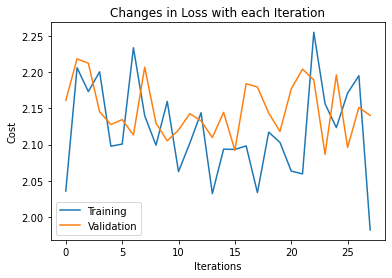

In [ ]:
plot_graph(train_cost_iter, valid_cost_iter, legends= ['Training', 'Validation'], ylabel= 'Cost', title = 'Changes in Loss with each Iteration' )

### Classification Accuarcy vs Iteration

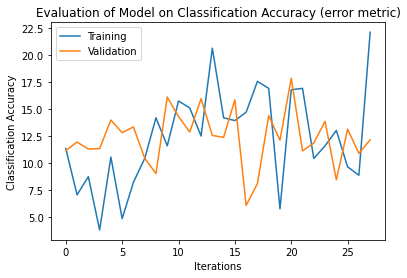

In [ ]:
plot_graph(train_accu_iter, valid_accu_iter, legends= ['Training', 'Validation'], ylabel= 'Classification Accuracy', title = 'Evaluation of Model on Classification Accuracy (error metric)' )

## Optimal Parameters

In [ ]:
print("For Convolutional layer, the shape of weights is (number of filters, channels, rows, columns)")
print("and of bias is (number of filters, 1).")
print()
print("For Fully Connected layer, the shape of weights is (number of neurons in previous layer, number of neurons in this layer)")
print(" and of bias is (number of neurons in this layer, 1).")

conv_counter = 1
fc_counter = 1
for layer in model.layers:
    if type(layer).__name__ == 'Conv':
      print("Convolutional Layer ", conv_counter)
      print()
      print("Weights: ")
      print(layer.weights)
      print("Bias ")
      print(layer.bias)
      print()
      conv_counter +=1
    
    if type(layer).__name__ == 'FC':
      print("Fully Connected Layer ", fc_counter)
      print()
      print("Weights: ")
      print(layer.weights)
      print("Bias ")
      print(layer.bias)
      print()
      fc_counter +=1
    

For Convolutional layer, the shape of weights is (number of filters, channels, rows, columns)
and of bias is (number of filters, 1).

For Fully Connected layer, the shape of weights is (number of neurons in previous layer, number of neurons in this layer)
 and of bias is (number of neurons in this layer, 1).
Convolutional Layer  1

Weights: 
[[[[-8.33488271e-02 -2.97345604e-02  4.61594951e-02 ... -7.89583948e-02
     1.31755442e-01  3.06162566e-02]
   [-7.23874266e-02 -2.76895101e-02  3.43670568e-02 ... -1.39502015e-01
    -1.11153517e-01  9.67548618e-02]
   [ 1.26862430e-02 -1.37456572e-01 -1.33856754e-02 ... -5.19004124e-02
     6.63019991e-02 -8.07791729e-02]
   ...
   [ 8.94373106e-03 -4.44073056e-02 -4.24144495e-02 ... -2.10930300e-01
    -6.95054239e-02 -1.51852640e-01]
   [ 8.33296796e-02 -2.00134529e-03 -1.11631738e-01 ... -7.57669094e-02
     5.66759322e-02 -3.97555630e-02]
   [ 6.03704184e-03  2.16120773e-01 -7.08612437e-02 ... -8.94866818e-02
    -3.32949509e-02  1.93501539e

Filters of Convolutional Layer Number:  1
Filters of Convolutional Layer Number:  2


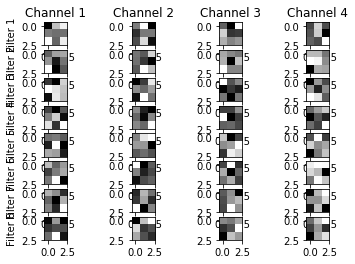

In [ ]:
conv_counter=1
for layer in model.layers:
  if type(layer).__name__ == 'Conv':
    print("Filters of Convolutional Layer Number: ", conv_counter)

    plot_weights(layer.weights)

    conv_counter += 1

## Saving Model

### Data Properties

In [ ]:
with open('/content/Model.npy', 'wb') as file:

  np.save(file, data.resize) #save resizing of image

  np.save(file, data.mean) #save zero centering info

  np.save(file, data.labels) #save labels

### Architecture Properties

In [ ]:
with open('/content/Model.npy', 'ab') as file:

  #save layers except loss function
  layers=[type(layer).__name__ for layer in model.layers[:-1]]
  np.save(file,  layers) 

  #save parameters and other associated hyperparameters

  for layer in model.layers[:-1]: #except loss function
 
    if type(layer).__name__ == 'Conv':

      np.save(file, layer.stride)
      np.save(file, layer.zero_padding)
      np.save(file, layer.weights)
      np.save(file, layer.bias)
    
    if type(layer).__name__ == 'Pool':
      
      np.save(file, layer.pooling_type)
      np.save(file, layer.filter_size)
      np.save(file, layer.stride)
      np.save(file, layer.zero_padding)
    
    if type(layer).__name__ == 'FC':
      
      np.save(file, layer.neurons)
      np.save(file, layer.weights)
      np.save(file, layer.bias)



## Error Metrics on Train, Validation and test set

### Train Set

In [ ]:
calculate_error(model, data, 'train')

The total cost on  train  data is  2.137111176845495
The Classification Accuracy on  train  data is  13.651877133105803



,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
basophil,39.0,60.0,31.0,80.0,40.0,36.0,81.0,18.0
eosinophil,93.0,259.0,108.0,237.0,87.0,109.0,237.0,185.0
erythroblast,168.0,421.0,185.0,405.0,149.0,218.0,419.0,275.0
ig,129.0,344.0,156.0,299.0,138.0,151.0,414.0,266.0
lymphocyte,60.0,163.0,96.0,120.0,80.0,47.0,132.0,160.0
monocyte,96.0,295.0,109.0,247.0,90.0,139.0,269.0,204.0
neutrophil,48.0,120.0,45.0,134.0,52.0,59.0,130.0,24.0
platelet,86.0,242.0,187.0,204.0,88.0,89.0,334.0,269.0


,Precision,Recall,F1 score
basophil,0.101299,0.054242,0.070652
eosinophil,0.196958,0.136029,0.160920
erythroblast,0.082589,0.201745,0.117200
ig,0.157617,0.173233,0.165057
lymphocyte,0.093240,0.110497,0.101138
monocyte,0.095928,0.163915,0.121027
neutrophil,0.212418,0.064484,0.098935
platelet,0.179453,0.192006,0.185517


### Validation Set

In [ ]:
calculate_error(model, data, 'valid')

The total cost on  valid  data is  2.2302133645028017
The Classification Accuracy on  valid  data is  16.530134581626683



,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
basophil,30.0,97.0,49.0,93.0,27.0,40.0,80.0,70.0
eosinophil,20.0,24.0,16.0,34.0,15.0,10.0,31.0,28.0
erythroblast,33.0,106.0,50.0,108.0,46.0,57.0,105.0,83.0
ig,37.0,79.0,32.0,76.0,25.0,27.0,69.0,54.0
lymphocyte,10.0,12.0,10.0,11.0,6.0,7.0,13.0,6.0
monocyte,17.0,76.0,25.0,56.0,27.0,30.0,87.0,30.0
neutrophil,105.0,259.0,111.0,208.0,92.0,112.0,302.0,192.0
platelet,7.0,16.0,12.0,20.0,8.0,9.0,10.0,47.0


,Precision,Recall,F1 score
basophil,0.061728,0.115830,0.080537
eosinophil,0.134831,0.035874,0.056671
erythroblast,0.085034,0.163934,0.111982
ig,0.190476,0.125413,0.151244
lymphocyte,0.080000,0.024390,0.037383
monocyte,0.086207,0.102740,0.093750
neutrophil,0.218682,0.433286,0.290664
platelet,0.364341,0.092157,0.147105


### Test Set

In [ ]:
calculate_error(model, data, 'test')

The total cost on  test  data is  2.2272426677608013
The Classification Accuracy on  test  data is  11.085112606025154



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: RuntimeWarning: invalid value encountered in double_scalars


,basophil,eosinophil,erythroblast,ig,lymphocyte,monocyte,neutrophil,platelet
basophil,58.0,94.0,43.0,95.0,31.0,37.0,94.0,39.0
eosinophil,24.0,60.0,44.0,57.0,23.0,30.0,71.0,68.0
erythroblast,107.0,321.0,121.0,287.0,112.0,139.0,306.0,216.0
ig,17.0,57.0,34.0,37.0,20.0,16.0,62.0,70.0
lymphocyte,27.0,72.0,34.0,75.0,33.0,31.0,102.0,66.0
monocyte,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0
neutrophil,25.0,54.0,23.0,51.0,18.0,32.0,52.0,29.0
platelet,1.0,11.0,6.0,4.0,9.0,7.0,9.0,18.0


,Precision,Recall,F1 score
basophil,0.118126,0.223938,0.154667
eosinophil,0.159151,0.089686,0.114723
erythroblast,0.075202,0.396721,0.126437
ig,0.118211,0.061056,0.080522
lymphocyte,0.075000,0.134146,0.096210
monocyte,0.000000,0.000000,NaN
neutrophil,0.183099,0.074605,0.106014
platelet,0.276923,0.035294,0.062609
